# Model Evaluation / Comparison

In [1]:
import torch
import os
from tools import plot_column_from_csv, torcherize_batch, get_data_loader, run_in_directory, import_from_nested_path

In [7]:
models_to_compare = [
    'models/customGPT/trained/customGPT_0.5m_tall_and_skinny',
    'models/customGPT/trained/customGPT_0.5m_5foot11_and_skinnyfat',
    'models/customGPT/trained/customGPT_0.5m_short_and_thick'#,
    #'models/fractal-head-attention/trained/FHA_GPT_0.3m_2024-05-07|13-05-29',
    #'models/fractal-head-attention/trained/FHA_GPT_0.8m_2024-05-05|10-54-35'
]

### first up we'll look at loss curves
notice that even with a log scale I had to splice out the first 10% to make the lines distinct

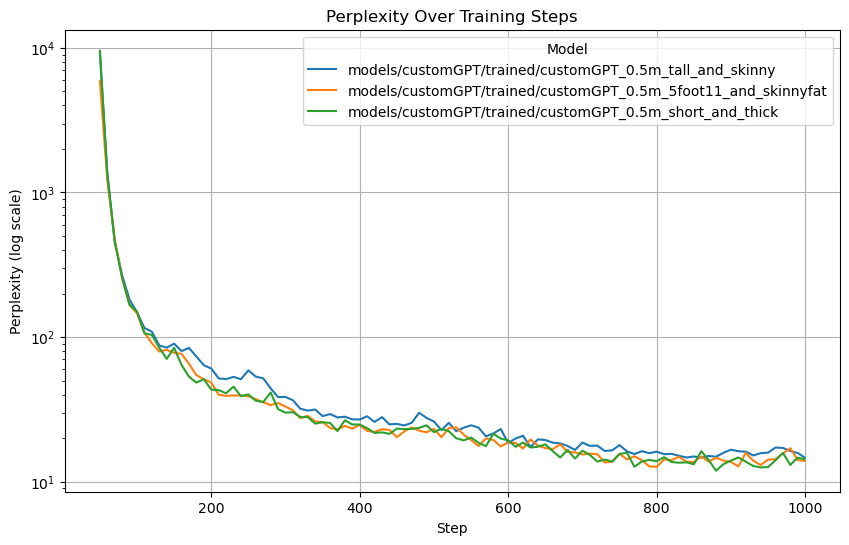

In [8]:
plot_column_from_csv(models_to_compare, 'Step', 'Perplexity', log_y=True, trim_percentage=5)

### now let's compare individual token accuracies

In [4]:
# Data preparation
data_loader = get_data_loader(batch_size = 1, split = 'validation') # batch size can only be 1 until i fix batched inference
text = next(iter(data_loader))

Found cached dataset json (/Users/tunadorable/.cache/huggingface/datasets/noanabeshima___json/noanabeshima--TinyStoriesV2-226173b7dd235c68/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


In [5]:
def calculate_topk_accuracy(logits, targets, k=5, padding_idx=None):
    # Calculate top-k predictions
    topk_indices = torch.topk(logits, k, dim=2).indices
    
    # Create a mask for valid (non-padding) targets
    if padding_idx is not None:
        valid_targets = targets != padding_idx
    else:
        valid_targets = torch.ones_like(targets, dtype=torch.bool)
    
    # Calculate correctness only where the target is valid
    correct = topk_indices.eq(targets.unsqueeze(2).expand_as(topk_indices)) & valid_targets.unsqueeze(2)
    
    # Calculate accuracy only on valid targets
    valid_correct = correct.any(dim=2)[valid_targets]
    if valid_correct.numel() == 0:
        return torch.tensor(0.0)  # return 0 if there are no valid targets to avoid division by zero
    else:
        return valid_correct.float().mean()

In [9]:
# Evaluate models
results = {}
for model_name in models_to_compare:
    path_parts = model_name.split('/')

    imported_objects = import_from_nested_path(['models', path_parts[1]], 'tools', ['load_model'])
    load_model = imported_objects.get('load_model')

    model, tokenizer, cfg = run_in_directory(load_model, os.path.join(path_parts[0], path_parts[1]), path_parts[3])

    x, y = torcherize_batch(tokenizer, text, max_seq_len = cfg.max_seq_len)
    # x and y are tensors shape [batch_size, max_seq_len] of dtype torch.int64
    
    with torch.no_grad():
        logits, _ = model(x)

    topk = 5
    topk_accuracy = calculate_topk_accuracy(logits, y, k = topk, padding_idx = cfg.vocab_len - 1)
    topk_indices = torch.topk(logits, topk, dim=2).indices
    
    # Store results
    results[model_name] = {
        'accuracy': topk_accuracy.item(),
        'topk_indices': topk_indices,
        'tokenizer': tokenizer
    }

502.592K parameters
ModelConfig(dim=64, device='cpu', tokenizer='bpe', vocab_len=2048, num_layers=10, second_resid_norm=False, mlp_hidden_mult=1, mlp_bias=False, mlp_nonlinearity='SiLU', mlp_gated=True, num_q_heads=10, num_kv_heads=2, head_dim=16, theta=10000, max_seq_len=512, scale_first_resid=True, norm_type='RMSNorm', norm_affine=True, norm_bias=True, eps=1e-06, max_batch_size=1)
Model(
  (token_embedder): Embedding(2051, 64)
  (layers): ModuleList(
    (0-9): 10 x Layer(
      (pre_attn_norm): Norm()
      (attn): MQA(
        (Wq): Linear(in_features=64, out_features=160, bias=False)
        (Wk): Linear(in_features=64, out_features=32, bias=False)
        (Wv): Linear(in_features=64, out_features=32, bias=False)
        (Wo): Linear(in_features=160, out_features=64, bias=False)
      )
      (pre_mlp_norm): Norm()
      (mlp): MLP(
        (Wgate): Linear(in_features=64, out_features=64, bias=False)
        (Wup): Linear(in_features=64, out_features=64, bias=False)
        (Wdown

In [11]:
# Define a function to format the model output
def format_model_output(model_name, data, topk, tokenizer):
    print(f"Model: {model_name}")
    print(f"  - Top-{topk} Accuracy: {data['accuracy']*100:.2f}%")
    
    # Extract the topk indices from the results
    topk_indices = data['topk_indices']
    
    # Assuming `y` is accessible here as the true targets or passed similarly to tokenizer
    batch_size, seq_len = topk_indices.shape[:2]
    
    # Display comparisons
    print('True\tPredicted')
    for j in range(25):
        true_token = tokenizer.expand_token(y[0, j].item())  # Get the true token
        predicted_tokens = [tokenizer.expand_token(idx) for idx in topk_indices[0, j]]  # List of predicted tokens
            
        # Display true and predicted tokens
        print(f"{true_token}\t{predicted_tokens}")
    print()

# Display the results for each model
for name, data in results.items():
    format_model_output(name, data, topk, data['tokenizer'])

Model: models/customGPT/trained/customGPT_0.5m_tall_and_skinny
  - Top-5 Accuracy: 45.51%
True	Predicted
One 	['On', 'One ', 'Li', 'To', 'Anna ']
da	['da', 'su', 'Ben a', 'Li', "Sue's "]
y	['', 'y ', 'dd', '', '']
, 	[', ', '', 'ing', ' t', ' a']
a 	['a ', 'Tim ', 'the', 'Max', 'so']
li	['li', 'boy', 'big', '', 'ca']
tt	['tt', 'ke', 'dy', 've', 'mb']
le	['le', '', 'er', 'uc', 'ite']
 g	[' g', ' bo', '', ' bird', ' c']
ir	['ir', 'arden', 'ro', 'ood', '']
l 	['l ', '', 'il ', '', 'x ']
na	['na', 'we', 'who', 'of ', 'wan']
me	['me', 'p ', 'ug', 'ke', 'loor']
d 	['d ', '', '', 've', '']
Li	['Li', 'Tim ', 'Sue', 'Amy', 'Mia']
ly	['ly', 'la', 'di', 'zz', 'st']
 	['', '. ', ' l', ' an', ' s']
we	['we', 'was', 'wan', 'dog', 'na']
n	['', 're', 'et', 't ', 'd ']
t 	['t ', '', 'g ', 'me', 'ug']
to t	['to t', 'for ', 'to ', 'to s', 'to f']
he	['he', '', 'ry', 'ou', 'al']
 p	[' p', '', ' tre', ' l', ' c']
ark	['ark', 'la', 'ret', 'ut', 'ond']
 	['', '. ', ' t', ' s', ' an']

Model: models/customGPT

# once i fix batched inference i need to redo the above code to use that to get a more accurate measurement. also should add some logic to ensure that padding tokens don't get graded and the example is one that doesn't show padding tokens

# in the future it'd be cool to build out an automated GPT-4 rater like what they used in the TinyStories paper

# also once the hyperparameter search module is working i should build a system that performs a regression on the hyperparameters tested to predict teacher-forcing topk accuracy. likely need to include both linear, quadratic, & interaction terms in the regression and then do a lasso to remove useless terms